In [38]:
import pandas as pd
import re

In [54]:
df = pd.read_csv('../../data/nips_with_track_cleaned.csv')
df.head()

,title,abstract,pdf_link,year,track,track_original,main_track
0,A Game Theoretic Approach to Class-wise Select...,Selection of input features such as relevant p...,http://papers.nips.cc/paper/by-source-2019-5315,2019,Adversarial Learning,Algorithms -- Adversarial Learning,Algorithms
1,A Little Is Enough: Circumventing Defenses For...,Distributed learning is central for large-scal...,http://papers.nips.cc/paper/by-source-2019-4657,2019,Adversarial Learning,Algorithms -- Adversarial Learning,Algorithms
2,A New Defense Against Adversarial Images: Turn...,Natural images are virtually surrounded by low...,http://papers.nips.cc/paper/by-source-2019-926,2019,Adversarial Learning,Algorithms -- Adversarial Learning,Algorithms
3,Tight Certificates of Adversarial Robustness f...,Strong theoretical guarantees of robustness ca...,http://papers.nips.cc/paper/by-source-2019-2720,2019,Adversarial Learning,Algorithms -- Adversarial Learning,Algorithms
4,Adversarial training for free!,"Adversarial training, in which a network is tr...",http://papers.nips.cc/paper/by-source-2019-1853,2019,Adversarial Learning,Algorithms -- Adversarial Learning,Algorithms


In [55]:
df.shape

(8337, 7)

In [56]:
df.groupby("main_track").size()

main_track
Algorithms                                         2185
Applications                                       1346
Data, Challenges, Implementations, and Software      34
Deep Learning                                      1280
NF                                                  421
Neuroscience and Cognitive Science                  315
Optimization                                        638
Probabilistic Methods                               751
Reinforcement Learning and Planning                 550
Theory                                              817
dtype: int64

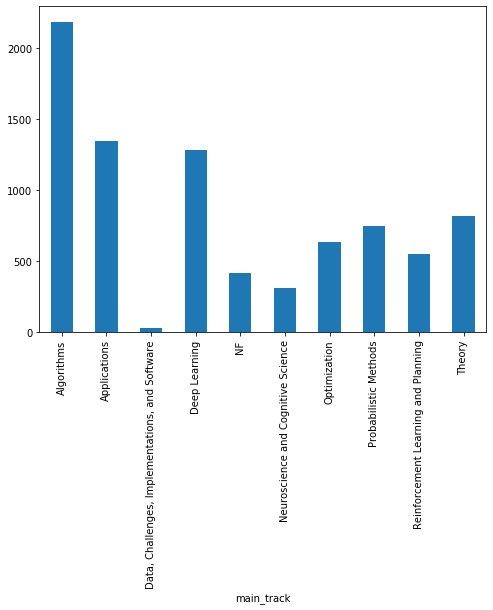

In [59]:
#check balance of classes

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
df.groupby('main_track').title.count().plot.bar(ylim=0)

plt.show()

In [60]:
#get number of observations with 'Not Found/NF' main_track
print(f"number of NF rows: {df[df['main_track']== 'NF'].shape}")

#drop NF rows
df = df[df['main_track'] != 'NF']

df = df.reset_index(drop=True)

print(f'remaining observations: {df.shape}')

number of NF rows: (421, 7)
remaining observations: (7916, 7)


As the number of papers for 'Data, Challenges, Implementations, and Software' is too low to add information meaningfully, I will drop that track

In [61]:
df = df[df['main_track'] != 'Data, Challenges, Implementations, and Software']

df.shape

(7882, 7)

In [62]:
#combine 'abstract' and 'title' to create the text column
df['text'] = df['abstract'] + " " + df['title']

In [63]:
df.to_csv("../../data/nips_cleaned.csv", index= False)

#### Number of papers by year: 

In [46]:
df.groupby('year').size()

year
2016    1415
2017    1887
2018    2770
2019    1810
dtype: int64

#### Number of papers by main track: 

In [47]:
df.groupby('main_track').size()

main_track
Algorithms                             2185
Applications                           1346
Deep Learning                          1280
Neuroscience and Cognitive Science      315
Optimization                            638
Probabilistic Methods                   751
Reinforcement Learning and Planning     550
Theory                                  817
dtype: int64

#### Number of papers by track: 

In [48]:
pd.DataFrame({'count':df.groupby('track').size()}).sort_values("count", ascending= False).head(10)

,count
track,
Learning Theory,350
Computer Vision,292
Generative Models,261
Reinforcement Learning,214
Convex Optimization,211
Deep Learning,183
Non-Convex Optimization,172
Online Learning,165
Bandit Algorithms,156


#### Summary stats of word count by year, track and main_track

In [49]:
#create a column of word_count per paper = length of abstract + title

strlen = []
for i,s in enumerate(df.abstract):   
    strlen.append(len(s) + len(df.title[i]))
    
df['word_count'] = strlen

df.to_csv("../../data/nips_cleaned.csv", index= False)

#word count by year
df.groupby('year')['word_count'].sum()

year
2016    1576325
2017    2103295
2018    3149830
2019    2149143
Name: word_count, dtype: int64

In [50]:
#word count by main_track
df.groupby('main_track')['word_count'].sum()

main_track
Algorithms                             2441567
Applications                           1578833
Deep Learning                          1475962
Neuroscience and Cognitive Science      413442
Optimization                            717716
Probabilistic Methods                   819252
Reinforcement Learning and Planning     617191
Theory                                  914630
Name: word_count, dtype: int64

In [51]:
#word count by track
df.groupby(['track']).agg({'word_count':'sum'}).sort_values("word_count", ascending= False).head(10)

,word_count
track,
Learning Theory,379105
Computer Vision,341408
Generative Models,290346
Reinforcement Learning,246025
Convex Optimization,228891
Deep Learning,214098
Non-Convex Optimization,198427
Optimization for Deep Networks,178659
Online Learning,174574


#### similarity across tracks and main_tracks 

In [71]:
#remove newline, special characters, stop words etc in the data

main_tracks = df.main_track.unique().tolist()

abstracts = []
for t in main_tracks:
    
    temp = df[df['main_track'] == t]
    abst = temp.text.tolist()
    string = ",".join(abst)
    #string = string.lower()
    #string = re.sub("-", " ", string)
    #string = string.strip()
    string = re.sub('[^a-zA-z\- ]+', '', string)
    
    abstracts.append(string)

In [72]:
mtrackdf = pd.DataFrame(main_tracks, columns = ['main_track'])

mtrackdf['text'] = abstracts

mtrackdf.to_csv("../../data/maintrack_abs_cleaned.csv", index=False)

In [73]:
print(f'shape: {mtrackdf.shape}')

mtrackdf.head(2)

shape: (8, 2)


,main_track,text
0,Algorithms,Selection of input features such as relevant p...
1,Applications,Large-scale distributed training of neural net...


In [74]:
#get most correlated terms across tracks

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [77]:
x = mtrackdf[['main_track', 'text']].copy()

#encode "main_track" column
lb = LabelEncoder()
x['main_track_encoded'] = lb.fit_transform(x['main_track'])

xdict = dict(x[['main_track', 'main_track_encoded']].values)

#target array
y = x['main_track_encoded'].copy()

In [79]:
#make the tf-idf weighted DTM

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=700,
                         stop_words='english',
                        norm='l2', lowercase=True, encoding='latin-1', 
                        ngram_range=(1, 4))

In [80]:
features = tfidf.fit_transform(x.text).toarray()
labels = x.main_track_encoded
features.shape

(8, 13421)

In [81]:
from sklearn.feature_selection import chi2
import numpy as np

N = 10
for abst, track in sorted(xdict.items()):
    features_chi2 = chi2(features, labels == track)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    #print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

  . Most correlated unigrams:
. regularizationwe
. thompson
. agree
. sort
. linkage
. wish
. multitask
. replaced
. incurred
. ordinal
  . Most correlated bigrams:
. generative framework
. method estimate
. learning rank
. matches lower
. algorithm improves
. framework called
. adversarial setting
. simple approach
. type generative
. bandit setting
  . Most correlated unigrams:
. deconvolutional
. editing
. protected
. annotation
. disparate
. transformer
. contents
. opinions
. odds
. databases
  . Most correlated bigrams:
. convolutional network
. differentially private
. strong baselines
. attention models
. fair representations
. visual concepts
. false positives
. post processing
. model general
. object detection
  . Most correlated unigrams:
. quantum
. vaes
. vae
. molecules
. regret
. penn
. format
. gru
. optimizer
. celeba
  . Most correlated bigrams:
. large batch
. sequence generation
. directly used
. memory cost
. information contained
. based generative
. batch sizes
